# Initialization

In [34]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bs4
import requests
from collections import defaultdict
from functools import reduce
%matplotlib inline

file_opioids = 'opioids.csv'
file_overdoses = 'overdoses.csv'
file_prescribers = 'prescriber-info.csv'
file_unemployment = 'state_unemployment_2013.csv'

# cosmetics for plots 
sns.set(font_scale = 1.5)

In [95]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix

In [7]:
opioids = pd.read_csv(file_opioids)
overdoses = pd.read_csv(file_overdoses)
prescribers = pd.read_csv(file_prescribers)
unemployment = pd.read_csv(file_unemployment, index_col='State')

Data Sources: 
Opioid, overdose, and prescriber dataframes come from [US Opioid Prescriptions/Overdoses](https://www.kaggle.com/apryor6/us-opiate-prescriptions) Kaggle dataset.

Unemployment dataframe is from the [US Bureau of Labor Statistics](https://www.bls.gov/lau/lastrk13.htm)

### A few small cleaning tasks. 

In [8]:
overdoses = overdoses.set_index('State')
overdoses['Population']=overdoses['Population'].str.replace(',', '')
overdoses['Deaths']=overdoses['Deaths'].str.replace(',','')
overdoses[['Population', 'Deaths']]=overdoses[['Population','Deaths']].apply(pd.to_numeric)

# rename column because it's confusing
prescribers= prescribers.rename({'State':'Abbrev'}, axis=1);
# take prescribers from states only
prescribers_states = prescribers[~prescribers.Abbrev.isin(['AA', 'AE', 'GU', 'VI', 'ZZ'])]
# add prescriber information to overdose df 
prescribers_per_state = []
for index, row in overdoses.iterrows(): 
    prescribers_per_state.append(prescribers.loc[prescribers['Abbrev']==row['Abbrev']].shape[0])
overdoses['Prescribers'] = prescribers_per_state

# prescribers per capita
overdoses['Prescribers Per Capita'] = overdoses['Prescribers']/overdoses['Population']
overdoses['Prescribers Per 100,000'] = overdoses['Prescribers Per Capita'] * 100000
# overdoses per capita
overdoses['Deaths Per Capita'] = (overdoses['Deaths']/ overdoses['Population']) 
overdoses['Deaths Per 100,000'] = overdoses['Deaths Per Capita']*100000

In [16]:
def provider_drugs(npi, df= prescribers, track_list = tracked_drugs):
    '''
    Given a provider NPI, returns a list of the drugs the provider prescribed
    Grabs this info from the prescribers database unless otherwise instructed, 
    Grabs info about which drugs are being tracked from tracked_drugs (built from prescribers)
    unless otherwise noted. 
    
    With track_list = detected_opioids, this returns the (recognized) opioids the provdier has prescribed! :)
    '''
    row = df[prescribers.NPI==npi]
    all_drugs = row[track_list].transpose()
    all_drugs.columns = ['num_prescriptions']
    return list(all_drugs.iloc[all_drugs.num_prescriptions.nonzero()].index)

prescribers['prescribed_drugs'] = prescribers['NPI'].apply(provider_drugs)

In [17]:
prescribers.head()

,NPI,Gender,Abbrev,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,prescribed_drugs
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"[HYDROCODONE.ACETAMINOPHEN, LORAZEPAM]"
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,35,1,"[ALPRAZOLAM, AMLODIPINE.BESYLATE, ATENOLOL, BU..."
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,25,0,"[BUPROPION.HCL.SR, BUPROPION.XL, CLONAZEPAM, D..."
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,1,"[ACETAMINOPHEN.CODEINE, ALENDRONATE.SODIUM, AM..."
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,17,28,0,0,0,1,"[AMITRIPTYLINE.HCL, FENTANYL, HYDROCODONE.ACET..."


In [18]:
specialty_counts = prescribers.Specialty.value_counts()
print('Total specialties recorded: {}'.format(len(specialty_counts)))
print('Specialties with > 100 prescribers recorded: {}'.format(len(specialty_counts[specialty_counts > 100])))

Total specialties recorded: 109
Specialties with > 100 prescribers recorded: 33


In [19]:
specialty_counts[specialty_counts > 100]

Internal Medicine                                                 3194
Family Practice                                                   2975
Dentist                                                           2800
Nurse Practitioner                                                2512
Physician Assistant                                               1839
Emergency Medicine                                                1087
Psychiatry                                                         691
Cardiology                                                         688
Obstetrics/Gynecology                                              615
Orthopedic Surgery                                                 575
Optometry                                                          571
Student in an Organized Health Care Education/Training Program     547
Ophthalmology                                                      519
General Surgery                                                    487
Gastro

In [32]:
tracked_drugs = list(prescribers.columns)[5:-1]
# Which drugs are most often prescribed? 
top_20_drugs = prescribers[tracked_drugs].aggregate(sum).sort_values(ascending = False)[:20].index
prescribers[tracked_drugs].aggregate(sum).sort_values(ascending = False).head()

LISINOPRIL              1176243
LEVOTHYROXINE.SODIUM    1144724
AMLODIPINE.BESYLATE     1107865
SIMVASTATIN             1032511
OMEPRAZOLE              1012238
dtype: int64

In [23]:
specialty_dummy = pd.get_dummies(prescribers['Specialty'])
dummy_prescribers = pd.concat([prescribers, specialty_dummy], axis = 1)
S = dummy_prescribers.copy().prescribed_drugs.apply(len)
dummy_prescribers = dummy_prescribers.assign(presc_drug_count = S.values)
dummy_columns = [i.strip() for i in specialty_dummy.columns]

In [38]:
dummy_prescribers.head()

,NPI,Gender,Abbrev,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,Student in an Organized Health Care Education/Training Program,Surgery,Surgical Oncology,Thoracic Surgery,Thoracic Surgery (Cardiothoracic Vascular Surgery),Unknown Physician Specialty Code,Unknown Supplier/Provider,Urology,Vascular Surgery,presc_drug_count
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,40
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,44
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


# Drug prescriptions based on specialty

For each of the most commonly prescribed drugs and all prescribers, we try to use prescriber specialty, the number of drugs the provider prescribes, and their opioid prescriber status to predict how much of each drug they will prescribe. 

In [45]:
scores = pd.Series(index = top_20_drugs)
for i in top_20_drugs: 
    reg = LinearRegression()
    X = dummy_prescribers[dummy_columns+ ['Opioid.Prescriber', 'presc_drug_count']] 
    y = dummy_prescribers[i].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state= 23) 

    reg.fit(X_train, y_train) 
    y_pred = reg.predict(X_test)
    score = reg.score(X_test, y_test)
    scores[i] = score 

In [46]:
scores.loc[scores.values > .6]

LISINOPRIL              0.739329
LEVOTHYROXINE.SODIUM    0.748927
AMLODIPINE.BESYLATE     0.697501
SIMVASTATIN             0.707720
OMEPRAZOLE              0.721306
ATORVASTATIN.CALCIUM    0.641050
METFORMIN.HCL           0.702683
METOPROLOL.TARTRATE     0.622792
HYDROCHLOROTHIAZIDE     0.649892
dtype: float64

We slice the dataset to only take popular prescribers 

In [41]:
popular_prescribers = dummy_prescribers[dummy_prescribers.Specialty.isin(specialty_counts[specialty_counts > 100].index)]

In [42]:
popular_prescribers.shape

(23545, 367)

In [47]:
scores_popular = pd.Series(index = top_20_drugs)
for i in top_20_drugs: 
    reg = LinearRegression()
    X = popular_prescribers[dummy_columns+ ['Opioid.Prescriber', 'presc_drug_count']] 
    y = popular_prescribers[i].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state= 23) 

    reg.fit(X_train, y_train) 
    y_pred = reg.predict(X_test)
    score = reg.score(X_test, y_test)
    scores_popular[i] = score 

In [48]:
scores_popular.loc[scores_popular.values > .6]

LISINOPRIL              0.725446
LEVOTHYROXINE.SODIUM    0.688866
AMLODIPINE.BESYLATE     0.709090
SIMVASTATIN             0.708054
OMEPRAZOLE              0.684445
ATORVASTATIN.CALCIUM    0.611289
METFORMIN.HCL           0.639714
HYDROCHLOROTHIAZIDE     0.656763
dtype: float64

Using only prescriber type, number of drugs prescribed in a year, and whether or not the prescriber prescribes opioids, we get reasonable prediction performance for drugs prescribed in a year. 

Let's take a closer look at performance for the case of predicting Lisinopril prescription numbers. 

In [53]:
lisinopril_reg = LinearRegression()
X = popular_prescribers[dummy_columns + ['Opioid.Prescriber', 'presc_drug_count']]
y = popular_prescribers.LISINOPRIL.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)
lisinopril_reg.fit(X_train, y_train)
y_pred = lisinopril_reg.predict(X_test)
score = lisinopril_reg.score(X_test, y_test)

residuals = (y_test - lisinopril_reg.predict(X_test))

In [61]:
print(score)

0.7254462987342492


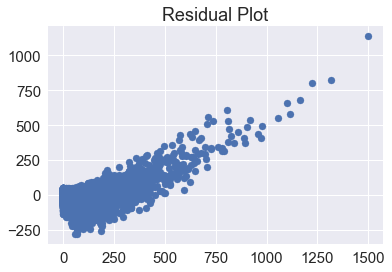

In [60]:
_ = plt.scatter(x=y_test, y = residuals)
_ = plt.title('Residual Plot')

The residual plot indicates a strong relationship between the target value and the error: this indicates that linear regression may not be the best choice for this application. In general, such a relationship between target and residuals indicate that a non-linear method is better. 

# Specialty Classification based on drug prescriptions 

In [67]:
specialties = ['Psychiatry', 'Cardiology', 'Obstetrics/Gynecology', 'Orthopedic Surgery', 'Optometry', 'Opthalmology']
specialist_slice = prescribers[prescribers.Specialty.isin(specialties)]

Here are the most commonly prescribed drugs for these specialities:

In [74]:
specialist_slice[tracked_drugs].aggregate(sum).sort_values(ascending = False)[:20]

ATORVASTATIN.CALCIUM         130227
LISINOPRIL                   109277
METOPROLOL.SUCCINATE         108367
CARVEDILOL                   106645
CLOPIDOGREL                  103138
AMLODIPINE.BESYLATE           98583
METOPROLOL.TARTRATE           97207
FUROSEMIDE                    91187
CLONAZEPAM                    76292
SIMVASTATIN                   74449
WARFARIN.SODIUM               71338
LOSARTAN.POTASSIUM            65562
QUETIAPINE.FUMARATE           59376
ALPRAZOLAM                    59059
HYDROCODONE.ACETAMINOPHEN     56295
TRAZODONE.HCL                 55802
ISOSORBIDE.MONONITRATE.ER     52857
RISPERIDONE                   50600
PRAVASTATIN.SODIUM            43700
LORAZEPAM                     43221
dtype: int64

In [83]:
specialist_top_10 = specialist_slice[tracked_drugs].aggregate(sum).sort_values(ascending = False)[:10].index

In [75]:
specialist_dummy = pd.get_dummies(specialist_slice['Specialty'])

We obtain dummy variables again as the target matrix for the multi-class classification:

In [76]:
specialist_dummy.head()

,Cardiology,Obstetrics/Gynecology,Optometry,Orthopedic Surgery,Psychiatry
8,0,0,1,0,0
13,1,0,0,0,0
20,0,1,0,0,0
49,0,0,1,0,0
51,0,1,0,0,0


In [78]:
specialist_slice.head()

,NPI,Gender,Abbrev,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber,prescribed_drugs
8,1023260569,M,TX,O.D.,Optometry,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[CIPROFLOXACIN.HCL, DORZOLAMIDE.TIMOLOL, LATAN..."
13,1548275050,M,OH,MD,Cardiology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[FUROSEMIDE, LISINOPRIL, METOPROLOL.SUCCINATE]"
20,1083907059,M,UT,M.D.,Obstetrics/Gynecology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,[OXYCODONE.HCL]
49,1295742583,M,KS,O.D.,Optometry,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[LATANOPROST, TIMOLOL.MALEATE, TRAVATAN.Z]"
51,1902866106,F,LA,M.D.,Obstetrics/Gynecology,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[ALENDRONATE.SODIUM, ESTRADIOL, FLUCONAZOLE, I..."


In [122]:
X = specialist_slice[specialist_top_10].values
y = specialist_slice.Specialty
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Fit logreg classifier to training data
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [123]:
logreg.classes_

array(['Cardiology', 'Obstetrics/Gynecology', 'Optometry',
       'Orthopedic Surgery', 'Psychiatry'], dtype=object)

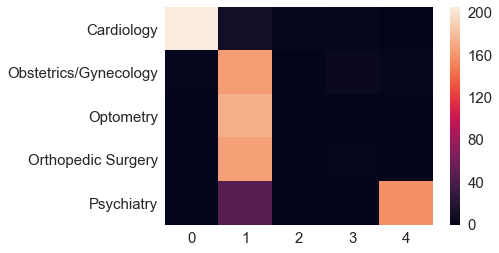

In [124]:
confusion = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(confusion, index = logreg.classes_)
_ = sns.heatmap(confusion)

Taking the 10 most popular drugs among the specialties allows us to distinguish between Cardiologists and Obstetrics/Gynecology specialists, but distinction is poor for the four other classes. 

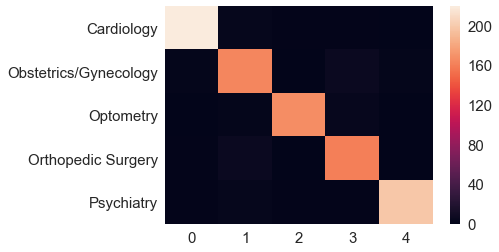

In [127]:
X = specialist_slice[tracked_drugs].values
y = specialist_slice.Specialty
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Fit logreg classifier to training data
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(confusion, index = logreg.classes_)
_ = sns.heatmap(confusion)

Taking all drugs in the dataset, we see that we can completely separate the specialties from one another. That indicates that there should be a collection of drugs that allow us to distinguish between the 5 specialities completely. Hopefully we don't have to take all 250 drugs. 

In [129]:
nonzero_col = specialist_slice.groupby('Specialty').sum().apply(lambda col: col> 0).sum().sort_values(ascending=True)
by_no_specialties = specialist_slice.groupby('Specialty')[nonzero_col.index].sum()

In [134]:
cols = by_no_specialties.columns
by_no_specialties

,NIACIN.ER,KLOR.CON.10,TOPROL.XL,IRBESARTAN,FLOVENT.HFA,BENICAR.HCT,INSULIN.SYRINGE,BRIMONIDINE.TARTRATE,BUMETANIDE,MORPHINE.SULFATE,...,METOPROLOL.TARTRATE,MIRTAZAPINE,MONTELUKAST.SODIUM,NAMENDA,OMEPRAZOLE,POTASSIUM.CHLORIDE,PRAVASTATIN.SODIUM,QUETIAPINE.FUMARATE,SIMVASTATIN,Opioid.Prescriber
Specialty,,,,,,,,,,,,,,,,,,,,,
Cardiology,3814,2374,5552,5888,14,2605,555,0,4140,0,...,95545,338,2088,1034,14661,28632,42330,391,72002,162
Obstetrics/Gynecology,0,0,0,0,0,103,36,0,34,25,...,539,50,153,82,868,453,589,104,702,144
Optometry,0,0,0,0,0,0,0,4565,0,0,...,39,11,14,11,11,12,11,13,33,3
Orthopedic Surgery,0,0,0,0,0,0,0,17,0,0,...,705,168,266,273,1049,715,651,131,1008,567
Psychiatry,0,0,0,0,0,0,0,0,0,66,...,379,27150,71,5780,1307,219,119,58737,704,78


In [148]:
by_no_specialties[cols[20:40]]

,LEVEMIR.FLEXPEN,NIFEDICAL.XL,DOXAZOSIN.MESYLATE,PRADAXA,NITROSTAT,GLIPIZIDE.XL,VALSARTAN,SOTALOL,ZIPRASIDONE.HCL,SEROQUEL.XR,ONDANSETRON.ODT,DILTIAZEM.HCL,RESTASIS,QUINAPRIL.HCL,FELODIPINE.ER,RANEXA,KLOR.CON.M20,EXELON,KLOR.CON.M10,GLYBURIDE
Specialty,,,,,,,,,,,,,,,,,,,,
Cardiology,61,1904,7499,17230,21104,319,2736,14169,0,0,0,3732,69,2468,772,15185,8662,66,1640,521
Obstetrics/Gynecology,11,25,27,31,54,0,14,82,0,0,12,31,0,34,0,20,81,0,0,22
Optometry,0,0,0,0,0,0,0,0,0,0,0,0,12828,0,0,0,0,0,0,0
Orthopedic Surgery,0,0,0,0,0,36,0,0,19,20,18,0,0,0,0,0,64,34,32,60
Psychiatry,0,0,0,0,0,0,0,0,14446,11428,0,0,0,0,13,0,0,2614,12,0


In [ ]:
by_

In [160]:
candidate_drugs = ['INSULIN.SYRINGE', 'BRIMONIDINE.TARTRATE', 'MORPHINE.SULFATE', 'METOLAZONE', 'LITHIUM.CARBONATE', 'TRAVATAN.Z', 'GLIPIZIDE.XL', 'RESTASIS', 'FELODIPINE.ER', 'GLYBURIDE']

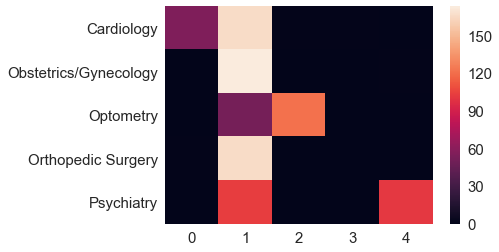

In [161]:
X = specialist_slice[candidate_drugs].values
y = specialist_slice.Specialty
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 23)

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Fit logreg classifier to training data
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(confusion, index = logreg.classes_)
_ = sns.heatmap(confusion)

In [162]:
by_no_specialties[candidate_drugs]

,INSULIN.SYRINGE,BRIMONIDINE.TARTRATE,MORPHINE.SULFATE,METOLAZONE,LITHIUM.CARBONATE,TRAVATAN.Z,GLIPIZIDE.XL,RESTASIS,FELODIPINE.ER,GLYBURIDE
Specialty,,,,,,,,,,
Cardiology,555,0,0,3787,0,25,319,69,772,521
Obstetrics/Gynecology,36,0,25,0,15,0,0,0,0,22
Optometry,0,4565,0,0,0,12203,0,12828,0,0
Orthopedic Surgery,0,17,0,56,0,0,36,0,0,60
Psychiatry,0,0,66,0,13031,0,0,0,13,0
